In [1]:
from datetime import datetime
date = datetime.now()
date_time = date.strftime("%Y-%m")
print(date)
print(date_time)

2023-08-16 15:48:19.265997
2023-08


In [13]:
import numpy as np 
test1 = np.array([[1,1,1],[1,1,1]])
test = [test1,test1,test1]
test = np.array(test)
test

array([[[1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1]]])

In [2]:
from snowslide_tests import test_mass_conservation
print(test_mass_conservation())

/Users/llemcf/opt/anaconda3/envs/lmd/lib/python3.8/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/Users/llemcf/opt/anaconda3/envs/lmd/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/opt/anaconda3/envs/lmd/lib/python3.8/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


TypeError: precipitations() takes 4 positional arguments but 6 were given

1500
500.0
17


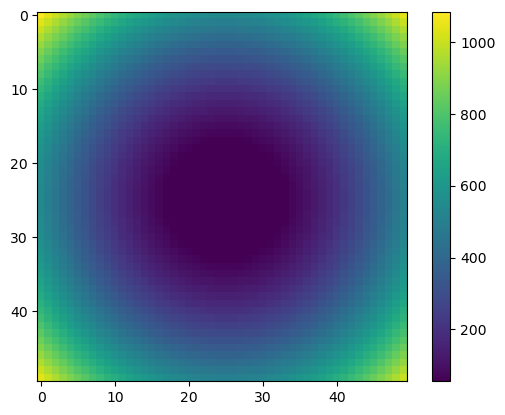

In [126]:
# Fonction de création d'un DEM idéalisé concave 

# Création du tableau parabolique 
import numpy as np
import matplotlib.pyplot as plt

# Création des coordonnées x, y
nb_pixels = 50
mean_slope = 2
factor = 3
resolution = 30

width = nb_pixels*30
diameter = width/factor
height = mean_slope*((width/2)-diameter)

x = np.arange(-width/2,width/2,resolution)
y = np.arange(-width/2,width/2,resolution)
X, Y = np.meshgrid(x, y)

# Calcul des coordonnées Z pour former une parabole
coef = height/(np.max(x)**2)
Z = coef*X**2 + coef*Y**2

index = int((width - diameter)/(2*resolution))+1
flat_value=Z[int(nb_pixels/2),index]

for i in range(nb_pixels) :
    for j in range(nb_pixels) :
        if ((i-(nb_pixels/2))**2 + (j-(nb_pixels/2))**2) < (diameter/(2*resolution))**2 : # Pour le cercle du milieu en gros 
            Z[i,j] = flat_value

plt.imshow(Z)
plt.colorbar()

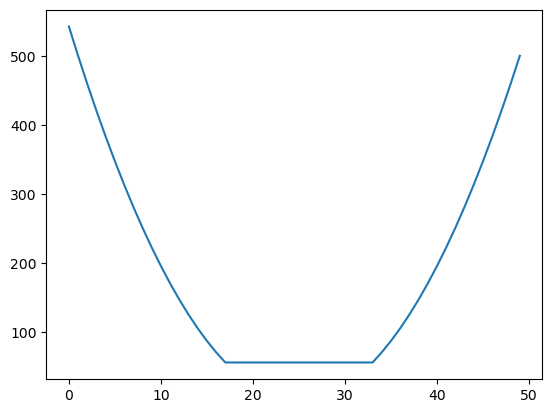

In [127]:
plt.plot(Z[25,:])

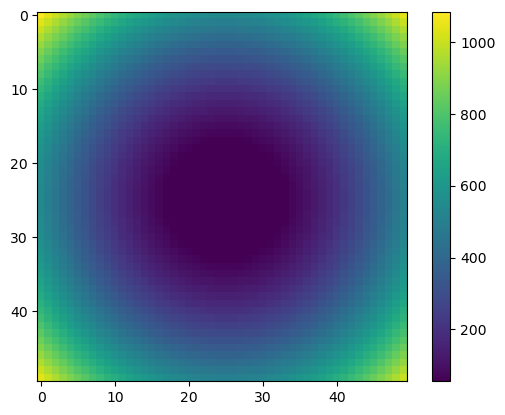

In [2]:
from snowslide_tests import ideal_concave_dem
import matplotlib.pyplot as plt

nb_pixels=50
mean_slope=2
factor=3
dem = ideal_concave_dem(nb_pixels,mean_slope,factor)

plt.imshow(dem)
plt.colorbar()


In [84]:
30*50

1500

$$ nb_{pixel} = distance/30 $$
$$ Mean_{slope} = \frac{dH}{\frac{distance}{2} - rayon} $$
Donc on peut déduire de ça moyennant d'imposer le rayon de calculer le dH et la distance qui sont les distances en x et en z associées...
Trouver la relation pour que le rayon et son altitude soient calculés directement. 
$$ factor = width/radius $$

In [90]:
400/(10*30)

1.3333333333333333

In [ ]:
### Compréhension des modules OGGM elevation_band_flowline
import numpy as np 
import panda as pd
import utils, cfg

def elevation_band_flowline(gdir, bin_variables=None, preserve_totals=True):
    """Compute "squeezed" or "collapsed" glacier flowlines from Huss 2012.

    This writes out a table of along glacier bins, strictly following the
    method described in Werder, M. A., Huss, M., Paul, F., Dehecq, A. and
    Farinotti, D.: A Bayesian ice thickness estimation model for large-scale
    applications, J. Glaciol., 1–16, doi:10.1017/jog.2019.93, 2019.

    The only parameter is cfg.PARAMS['elevation_band_flowline_binsize'],
    which is 30m in Werder et al and 10m in Huss&Farinotti2012.

    Currently the bands are assumed to have a rectangular bed.

    Before calling this task you should run `tasks.define_glacier_region`
    and `gis.simple_glacier_masks`. The logical following task is
    `fixed_dx_elevation_band_flowline` to convert this to an OGGM flowline.

    Parameters
    ----------
    gdir : :py:class:`oggm.GlacierDirectory`
        where to write the data
    bin_variables : str or list of str
        variables to add to the binned flowline
    preserve_totals : bool or list of bool
        whether or not to preserve the variables totals (e.g. volume)
    """

    # Variables
    bin_variables = [] if bin_variables is None else utils.tolist(bin_variables)
    out_vars = []
    out_totals = []
    grids_file = gdir.get_filepath('gridded_data')
    with utils.ncDataset(grids_file) as nc:
        glacier_mask = nc.variables['glacier_mask'][:] == 1
        topo = nc.variables['topo_smoothed'][:]

        # Check if there and do not raise when not available
        keep = []
        for var in bin_variables:
            if var in nc.variables:
                keep.append(var)
            else:
                log.warning('{}: var `{}` not found in gridded_data.'
                            ''.format(gdir.rgi_id, var))
        bin_variables = keep
        for var in bin_variables:
            data = nc.variables[var][:]
            out_totals.append(np.nansum(data) * gdir.grid.dx ** 2)
            out_vars.append(data[glacier_mask])

    preserve_totals = utils.tolist(preserve_totals, length=len(bin_variables))

    # Slope
    sy, sx = np.gradient(topo, gdir.grid.dx)
    slope = np.arctan(np.sqrt(sx ** 2 + sy ** 2))

    # Clip following Werder et al 2019
    slope = utils.clip_array(slope, np.deg2rad(0.4), np.deg2rad(60))
    # En gros les pentes inf à 0.4 sont fixées à 0.4 et sup à 60 sont fixées à 60... Comme dit dans l'article. 

    topo = topo[glacier_mask]
    slope = slope[glacier_mask]

    bsize = cfg.PARAMS['elevation_band_flowline_binsize'] # Taille de la bin

    # Make nice bins ensuring to cover the full range with the given bin size
    maxb = utils.nicenumber(np.max(topo), bsize)
    minb = utils.nicenumber(np.min(topo), bsize, lower=True)
    bins = np.arange(minb, maxb + 0.01, bsize)

    # Some useful constants
    min_alpha = np.deg2rad(0.4)
    max_alpha = np.deg2rad(60)

    if len(bins) < 3:
        # Very low elevation range
        bsize = cfg.PARAMS['elevation_band_flowline_binsize'] / 3
        maxb = utils.nicenumber(np.max(topo), bsize)
        minb = utils.nicenumber(np.min(topo), bsize, lower=True)
        bins = np.arange(minb, maxb + 0.01, bsize)
        if len(bins) < 3:
            # Ok this just not gonna work
            raise InvalidDEMError('({}) DEM altidude range too small.'
                                  .format(gdir.rgi_id))

    # Go - binning
    df = pd.DataFrame() # On créé un dataframe panda 
    topo_digi = np.digitize(topo, bins) - 1  # I prefer the left
    # np.digitize(x,bins) : retourne les indices des 'bins' auxquelles chaque valeur de l'array x appartiennent.
    # C'est donc un tableau d'indice de même taille que x. 
    for bi in range(len(bins) - 1):
        # The coordinates of the current bin
        bin_coords = topo_digi == bi

        # Bin area
        bin_area = np.sum(bin_coords) * gdir.grid.dx ** 2
        if bin_area == 0:
            # Ignored in this case - which I believe is strange because deltaH
            # should be larger for the previous bin, but this is what they do
            # according to Zekollari 2019 review
            df.loc[bi, 'area'] = np.NaN
            continue
        df.loc[bi, 'area'] = bin_area
        # ds.loc() --> Access a group of rows and columns by label(s) or a boolean array.
        
        # Bin average elevation
        df.loc[bi, 'mean_elevation'] = np.mean(topo[bin_coords])

        # Bin averge slope
        # there are a few more shenanigans here described in Werder et al 2019
        s_bin = slope[bin_coords]
        # between the 5% percentile and the x% percentile where x is some magic
        qmin = np.quantile(s_bin, 0.05)
        x = max(2 * np.quantile(s_bin, 0.2) / np.quantile(s_bin, 0.8), 0.55)
        x = min(x, 0.95)
        qmax = np.quantile(s_bin, x)
        sel_s_bin = s_bin[(s_bin >= qmin) & (s_bin <= qmax)]
        if len(sel_s_bin) == 0:
            # This can happen when n pix is small. In this case we just avg
            avg_s = np.mean(s_bin)
        else:
            avg_s = np.mean(sel_s_bin)

        # Final clip as in Werder et al 2019
        df.loc[bi, 'slope'] = utils.clip_scalar(avg_s, min_alpha, max_alpha)

        # Binned variables
        with warnings.catch_warnings():
            # This can trigger an empty mean warning
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            for var, data in zip(bin_variables, out_vars):
                df.loc[bi, var] = np.nanmean(data[bin_coords])

    # The grid point's grid spacing and widths
    df['bin_elevation'] = (bins[1:] + bins[:-1]) / 2
    df['dx'] = bsize / np.tan(df['slope'])
    df['width'] = df['area'] / df['dx']

    # Remove possible NaNs from above
    if not bin_variables:
        df = df.dropna()
    else:
        # only remove if all bin_variables are NaN
        df = df.dropna(how='all', subset=bin_variables)

    # Check for binned vars
    for var, data, in_total, do_p in zip(bin_variables, out_vars, out_totals,
                                         preserve_totals):
        if do_p:
            out_total = np.nansum(df[var] * df['area'])
            if out_total > 0:
                df[var] *= in_total / out_total

    # In OGGM we go from top to bottom
    df = df[::-1]

    # The x coordinate in meter - this is a bit arbitrary but we put it at the
    # center of the irregular grid (better for interpolation later
    dx = df['dx'].values
    dx_points = np.append(dx[0]/2, (dx[:-1] + dx[1:]) / 2)
    df.index = np.cumsum(dx_points)
    df.index.name = 'dis_along_flowline'

    # Store and return
    df.to_csv(gdir.get_filepath('elevation_band_flowline'))


@entity_task(log, writes=['inversion_flowlines'])
def fixed_dx_elevation_band_flowline(gdir, bin_variables=None,
                                     preserve_totals=True):
    """Converts the "collapsed" flowline into a regular "inversion flowline".

    You need to run `tasks.elevation_band_flowline` first. It then interpolates
    onto a regular grid with the same dx as the one that OGGM would choose
    (cfg.PARAMS['flowline_dx'] * map_dx).

    Parameters
    ----------
    gdir : :py:class:`oggm.GlacierDirectory`
        where to write the data
    bin_variables : str or list of str
        variables to add to the interpolated flowline (will be stored in a new
        csv file: gdir.get_filepath('elevation_band_flowline',
        filesuffix='_fixed_dx').
    preserve_totals : bool or list of bool
        whether or not to preserve the variables totals (e.g. volume)
    """

    df = pd.read_csv(gdir.get_filepath('elevation_band_flowline'), index_col=0)

    map_dx = gdir.grid.dx
    dx = cfg.PARAMS['flowline_dx']
    dx_meter = dx * map_dx
    nx = int(df.dx.sum() / dx_meter)
    dis_along_flowline = dx_meter / 2 + np.arange(nx) * dx_meter

    while dis_along_flowline[-1] > df.index[-1]:
        # do not extrapolate
        dis_along_flowline = dis_along_flowline[:-1]

    while dis_along_flowline[0] < df.index[0]:
        # do not extrapolate
        dis_along_flowline = dis_along_flowline[1:]

    nx = len(dis_along_flowline)

    # Interpolate the data we need
    hgts = np.interp(dis_along_flowline, df.index, df['mean_elevation'])
    widths_m = np.interp(dis_along_flowline, df.index, df['width'])

    # Correct the widths - area preserving
    area = np.sum(widths_m * dx_meter)
    fac = gdir.rgi_area_m2 / area
    log.debug('(%s) corrected widths with a factor %.2f', gdir.rgi_id, fac)
    widths_m *= fac

    # Additional vars
    if bin_variables is not None:
        bin_variables = utils.tolist(bin_variables)

        # Check if there and do not raise when not available
        keep = []
        for var in bin_variables:
            if var in df:
                keep.append(var)
            else:
                log.warning('{}: var `{}` not found in gridded_data.'
                            ''.format(gdir.rgi_id, var))
        bin_variables = keep

        preserve_totals = utils.tolist(preserve_totals,
                                       length=len(bin_variables))
        odf = pd.DataFrame(index=dis_along_flowline)
        odf.index.name = 'dis_along_flowline'
        odf['widths_m'] = widths_m
        odf['area_m2'] = widths_m * dx_meter
        for var, do_p in zip(bin_variables, preserve_totals):
            interp = np.interp(dis_along_flowline, df.index, df[var])
            if do_p:
                in_total = np.nansum(df[var] * df['area'])
                out_total = np.nansum(interp * widths_m * dx_meter)
                if out_total > 0:
                    with warnings.catch_warnings():
                        # This can trigger a double error
                        warnings.filterwarnings("ignore", category=RuntimeWarning)
                        interp *= in_total / out_total
            odf[var] = interp
        odf.to_csv(gdir.get_filepath('elevation_band_flowline',
                                     filesuffix='_fixed_dx'))

    # Write as a Centerline object
    fl = Centerline(None, dx=dx, surface_h=hgts, rgi_id=gdir.rgi_id,
                    map_dx=map_dx)
    fl.order = 0
    fl.widths = widths_m / map_dx
    fl.is_rectangular = np.zeros(nx, dtype=bool)
    fl.is_trapezoid = np.ones(nx, dtype=bool)

    if gdir.is_tidewater:
        fl.is_rectangular[-5:] = True
        fl.is_trapezoid[-5:] = False

    gdir.write_pickle([fl], 'inversion_flowlines')
    gdir.add_to_diagnostics('flowline_type', 'elevation_band')